LTR (Lightning Tracking Routine) for linear storm identification, tracking, and sampling using lightning data:
------
This is the main notebook for running the LTR. The LTR encapsulates identifying, tracking, and generating sampling grids for examining the through-width and length variability of storm properties (i.e, flash rates, surface thermodynamics, and microphysics). The LTR is currently set to mainly use LMA data, but the potential and framework for expanded use with GLM data is also provided.

The main functionality of the LTR is as follows: (More details can be found in Salinas and Chmielewski, 2023-in prep)

    1) Object Identification - Makes use of scikit learn and scipy.ndimage to identify the largest electrically active regions of a linear storm system (i.e., squall line, MCS, QLCS). Flash extent densities are employed to define the lightning flash footprint. These grids can be generated at any time interval (e.g., 1, 5, 10 minute) for examining storm properties at different time-scales.  The object identification employes morphological operations to identify and define lightning blobs, or flash objects (FOBS), that define the most convective region of a linear storm system. Identified FOBs are fit with an ellipse of configurable size (i.e., width and height) in order to make tracking more consistent (see next point).
    
    2) Tracking - Electrically active regions of linear storm systems represented by ellipses due to their similar shapes (elongated axis) and consistent feature tracking and centroid consistency. Tracking is done by identifying the largest object in the analysis domain (user defined). The FOB and ellipse orientations are smoothed in time in order to maintain consistent storm system orientation. Centroids are later smoothed to provide a more smooth storm system track for consistent storm feature sampling using the sampling grid.
    
    3) Sampling - Storm sampling is done by first generating a sampling axis through the semi-major axis of the tracking ellipses. This sampling axis spans from focal-point-to-focal-point of each tracked ellipse and is defined by a configurable number of points. The number of points defining the number of sample segments used to construct the grid. After these points are defined, the sample segments are generated by first setting a y-offset which determines the distance each segment spans from their center positions along the sample axis. Users can define this variable, but default is 150 km above and below. Then, a configurable number of points (default=100) is used to construct line segments that run through each point along the sample axis--these are the newly formed sample segments. Finally, these segments are rotated by the FOB orientation + 180 degrees so that they are always orthogonal to the convective line of the storm as we desire to sample through its entire width into the ambient enviornment.
    
These steps are presented in the notebook in order, and the configurable terms are defined before each routine so as to make customization more accessible to the user. Questions for running the notebook, or if errors occur, can be directed to: vicente.salinas@noaa.gov.

<font color='red'>ATTENTION:</font> <i>Make sure case is of linear storm mode-broken or mixed mode storms will cause issues with the LTR. Future work will likely implement concepts similar to TOBAC and trackpy in order to keep track of multiple features to be able to handle tracking broken linear systems like those of PERiLS IOP1 on 02/16/2023.</i>

In [37]:
%matplotlib inline
#Plotting Imports
#----
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as path_effects
import cmocean as cm
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from copy import copy
from matplotlib.collections import PatchCollection
import seaborn as sns
sns.reset_orig()

#For colormaps
#---
import metpy
from metpy.plots import colortables as ct
ref = ct.get_colortable('NWSReflectivity')
vel = ct.get_colortable('Carbone42')
color_keys = metpy.plots.colortables.keys()

#Basic Imports
#---
import numpy as np
import glob
import xarray as xr
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

#Geometry Bounds
#---
import shapely as sh
from shapely.geometry import Polygon,Point

#Image manipulation
#---
from scipy import ndimage 
from scipy.ndimage import gaussian_filter as gf
from scipy.interpolate import interpn,interp2d,interpnd
import backend as bk 
# import GLMParallaxCorrection as gpc

In [2]:
warnings.filterwarnings("ignore")

Functions for Tracking:
-----
The variables below define the functions used for the LTR. These functions are as listed:

    1) shift_ellipse = function to move ellipse by some distance forward or backward from its initial location as determined by the FED object identification.
    2) smooth_angle  = function to smooth the orientation of the track object for each iteration of the LTR.
    3) tracking      = main LTR tracking function.
    4) rotate        = function used to rotate points in order to define the sample axis and sample grid.
    5) plot_tracking_overview = function to plot the FED cumulative sum data with tracked ellipses overlaid (non smoothed path).
    5) gen_sample_points      = function to generate the sample points through the ellipses semi-major axis, or long axis.

In [3]:
#Predefine the functions used for tracking and tracking modification:
#-----
shift_ellipse          = bk.shift_ellipse
smooth_angle           = bk.smooth_angle
tracking               = bk.tracking
rotate                 = bk.rotate
plot_tracking_overview = bk.plot_tracking_overview
gen_sample_points      = bk.gen_sample_points

# Read in Param Case File:
-----

Here, the user must read in the param files for the desired case. Within these files are the case specific parameters used to define:

    A) The case name (ID), 
    B) Time-delta spanning each time frame, 
    C) LMA network name (or GLM), 
    D) Network lat lon center positions for coordinate transformations relative to network center, 
    E) Analysis domain lat and lon ranges used for plotting in this notebook,
    F) Spacing which determines the grid spacing of the domain
    G) Start and end time of the analysis period (string format in UTC HHMMSS), can be overwritten manually,
    H) grid boundaries and extents if constructing space-time plots is desired.
   
### Track on:

Users then have ability to chose if tracking method is for LMA or GLM FED (Flash Extent Density) data. Note: Users must already have GLM data (L2-LCFA) in order to use that option (still in testing).

### User Configurables:
User configurable variables for customizing the identification, tracking, and sampling methods. These include:

    A) gauss_smooth = used to smooth the FED gridded data for generating lightning blobs,
    B) constant_feature = used to toggle between using a tracking ellipse of constant size for consistent sampling, or adaptive ellipses that match FOB size,
    C) set_width = configurable option to set constant ellipse width (minor axis length) if constant_feature if TRUE,
    D) set_height = configurable option to set constant ellipse height (major axis length) if constant_feature is TRUE,
    E) dx = grid spacing of FED grids
    F) save_fig = optiont to toggle saving tracking frames, and overview figures
    G) offset = option to offset sample axis by some distance set by user--recommend keeping at 0 km.
    
### Coordinate Transformations:
Finally, the projected coordinate system is defined by the LMA network center for transforming LMA data from geographic coordinates (lon, lat) to cartesian coordinates centered around LMA network domain. The case base date (start of day) is set using case param variables.

In [38]:
#-----------------------------------
#Read in gridding parameters--shared 
#across GLM and LMA gridding routines:
#-----------------------------------
set_dt      = '5min' #REDO 1min and use better gauss smoothing to smooth centroids! Based on factor diff from previous 10min->5min->1min or 1->2->5!
set_case    = '20220612' #YYYYMMDD
target      = f'CaseParams/{set_dt}/FlashGriddingParams_{set_case}.txt'
params      = eval(open(target, 'r').read())
case        = params['Case']
network     = params['network']
network_lon = params['network_lon']
network_lat = params['network_lat']
lat_ranges  = params['lat_range']
lon_ranges  = params['lon_range']
spacing     = params['spacing']
dtime       = params['dt']
start       = params['start_time']
end         = params['end_time']
grid_bnds   = params['grid_extent']
grid_dx     = params['grid_spacing']

#-----------------------------------
#Set data to use for tracking
#-----------------------------------
track_method='LMA'#'GLM'

#-----------------------------------
#Tracking Parameters:
#-----------------------------------
gauss_smooth     = 1         #Smooth lightning FED/GED field to ensure one large feature is identified #eg. 10 for 102721; 3 for 061221; 4 for IOPs
constant_feature = True      #Boolean, if True, tracked feature will be predefined by constant object width and height. If False, tracked geometry adapts with GED/FED footprint
set_width        = 500       #(km) for constant feature--ensure all sampling follow same track
set_height       = 125       #(km) for constant feature--ensure all sampling follow same track
dx               = grid_dx   #set grid spacing--not used unless interpolating onto grid
save_fig         = True      #Save tracked frames for reference
#For shifting the line--suggest doing this in later analysis routines and keeping this 
#defined as the axis of largest variance of Lightning (Group) activity.
offset           = 0         #move tracking centroid by x km forwards or backwards to sample different regions of a storm

#-----------------------------------
#Start map projection
#-----------------------------------
geo,proj,(nlon,nlat) = bk.LMA_projection(network,network_lat,network_lon)
base_dat             = dt.datetime(int(case[:4]),int(case[4:6]),int(case[6:])) #should be basedate but I'll fix that later.
print('Analysis Parameters:')
print('---------')
try:
    print('Network Centered on Lon={0:.2f} and Lat={1:.2f}'.format(nlon[0],nlat[0]))
except:
    print('Network Centered on Lon={0:.2f} and Lat={1:.2f}'.format(nlon,nlat))
print('For Selected Case:',case)
print('At LMA network:',network)
print('Case base date and time:',base_dat)
print('Start',start)
print('End',end)
print('Frame dt:',dtime)

Analysis Parameters:
---------
Network Centered on Lon=-90.29 and Lat=35.75
For Selected Case: 20230405
At LMA network: MLMA
Case base date and time: 2023-04-05 00:00:00
Start 110000
End 190000
Frame dt: 300


Get GLM Data Files (only if available)
-----
If users desire to use GLM FED data instead of LMA FED, this code block will build a list of available GLM FED data files, else an alert is given.

In [39]:
if track_method=='GLM':
    try:
        #Previous version used L2 GLM data subsetted by LMA FDE, but this is not necessary an generating these files only consumes more time---lots more time.
        #Instead, we use the GLM L3 gridded files that have already been subsetted in space:
        #To do this make sure both LMA and GLM grids are gridded on same domain with same spatial extents (see GLM gridding script and LMA_GRIDS.ipynb)
        glm_grid_files = sorted(glob.glob(f'../LightningObs/GLM/grids/{case}/*.nc'))
        if len(glm_grid_files) > 0:
            print('Getting glm files.')
        else:
            print('No glm files found.')
    except:
        print(f'No GLM data used for {network} case')
else:
    print('No GLM Data requested or available.')

No GLM Data requested or available.


Setting Analysis Time:
------

This code block generates an array of the seconds-since-start-of-day times defining the time frames. If using GLM data, we make use of the file times in the GLM files to define them (may be omitted). Otherwise, the start and end times defined in the params file will be used with the dt (time-delta) in order to construct them. The frame duration is then calculated for reference. All times used in analyses are in seconds since start of day.

In [40]:
try:
    find_ts_idx = int(glm_grid_files[0].find('G16')+12)
    find_te_idx = int((-16*2) - 3)
    frame_times = np.array([gfiles[find_ts_idx:find_te_idx] for gfiles in glm_grid_files])
    frame_tfmt  = np.array([dt.datetime(base_dat.year,base_dat.month,base_dat.day,
                                        int(gf[:2]),int(gf[2:4]),int(gf[4:6])) for gf in frame_times])
    frame_seconds= np.array([(ftime - base_dat).total_seconds() for ftime in frame_tfmt])
    glm_times    = frame_seconds.copy()
    frame_dur    = np.unique(glm_times[1:] - glm_times[:-1])
    print('Files Gridded at {0} s, or {1} min, intervals'.format(frame_dur[0],frame_dur[0]/60))
except:
    stime = dt.datetime(int(case[:4]),int(case[4:6]),int(case[6:]),
                        int(start[:2]),int(start[2:4]),int(start[4:])) 

    etime = dt.datetime(int(case[:4]),int(case[4:6]),int(case[6:]),
                        int(end[:2]),int(end[2:4]),int(end[4:])) 

    stime_s = float((stime - base_dat).total_seconds())
    etime_s = float((etime - base_dat).total_seconds())
    if etime_s < stime_s:
        etime_s = etime_s + 86400

    frame_seconds = np.arange(stime_s,etime_s,int(dtime))
    frame_times   = [(base_dat+dt.timedelta(seconds=s)) for s in frame_seconds]
    frame_dur     = int(dtime)
    print('Files Gridded at {0} s, or {1} min, intervals'.format(dtime,dtime/60))
print(frame_seconds,len(frame_seconds))

Files Gridded at 300 s, or 5.0 min, intervals
[39600. 39900. 40200. 40500. 40800. 41100. 41400. 41700. 42000. 42300.
 42600. 42900. 43200. 43500. 43800. 44100. 44400. 44700. 45000. 45300.
 45600. 45900. 46200. 46500. 46800. 47100. 47400. 47700. 48000. 48300.
 48600. 48900. 49200. 49500. 49800. 50100. 50400. 50700. 51000. 51300.
 51600. 51900. 52200. 52500. 52800. 53100. 53400. 53700. 54000. 54300.
 54600. 54900. 55200. 55500. 55800. 56100. 56400. 56700. 57000. 57300.
 57600. 57900. 58200. 58500. 58800. 59100. 59400. 59700. 60000. 60300.
 60600. 60900. 61200. 61500. 61800. 62100. 62400. 62700. 63000. 63300.
 63600. 63900. 64200. 64500. 64800. 65100. 65400. 65700. 66000. 66300.
 66600. 66900. 67200. 67500. 67800. 68100.] 96


Set LMA (or GLM) time frames:
---
Not really necessary as long as you get the radar data at the closest start and end frame times. If using GLM data, get the relative time frames and skip a # of time frames if desired. If using LMA, do the same as for the GLM. Analysis time information is printed including number of frames and start and stop times. Finally, define a time_bnds variable which serves as the right-edge of the time frame bins used later to construct LMA (or GLM) subsets corresponding to time-chunks.

In [41]:
if track_method == 'GLM':
    #Here we reassign the glm_times variable to just be t_frames:
    init_time = glm_times[0]
    final_time= glm_times[-1]
    #Added feature--specify is times are to be skipped and by how many
    #this will carry through out the rest of the notebook
    skip_times= 0 
    t_frames  = glm_times[skip_times:] 
    t_bnds    = t_frames.copy() + frame_dur
else:
    skip_times = 0
    t_frames  = frame_seconds[skip_times:]
    init_time = t_frames[0]
    final_time= t_frames[-1]
    t_bnds    = t_frames.copy() + dtime
    
print('Gridded Frames for Analysis:')
print('---------')
print('Total Frames: {0}'.format(len(t_frames)))
print('Start Frame: {0}'.format(init_time))
print('End Frame: {0}'.format(final_time))

Gridded Frames for Analysis:
---------
Total Frames: 96
Start Frame: 39600.0
End Frame: 68100.0


# Get Flash Extent (LMA) or Group Density (GLM) Grids for Tracking:
--------
Here, if GLM data is chosen, we reduce the file size for faster tracking by dropping all variables other than those that are 'needed'.

In [42]:
if track_method == 'GLM':
    #Look at available variables and drop those not needed for faster load time when reading glm grids:
    test_grid = xr.open_dataset(glm_grid_files[0])
    variables = np.array(list(test_grid.keys()))
    needed    = np.array(['goes_imager_projection','nominal_satellite_subpoint_lon',
                          'nominal_satellite_subpoint_lat','group_extent_density',
                          'group_centroid_density'])
    drop_idx  = [var not in needed for var in variables]
    drop      = variables[drop_idx]

### Set tracking field:
Set the tracking field based on the track_method defined above. If GLM, use the group extent densities (GED), else use the LMA FED. Files are opened here.

In [43]:
if track_method == 'GLM':
    #GLM FIELDS:
    #----------
    GLM_GCD = np.array([xr.open_dataset(gf,drop_variables=drop).group_centroid_density.values for gf in glm_grid_files])
    GLM_GED = np.array([xr.open_dataset(gf,drop_variables=drop).group_extent_density.values   for gf in glm_grid_files])
else:
    #LMA FIELD:
    #----------
    lma     = xr.open_dataset(f'LightningData/LMA/gridded/{set_dt}/OKLMA_GRIDS_{case[2:]}_{set_dt}.nc')
    LMA_FED = lma.flash_extent_density.values

### Define the LMA (or GLM) coordinates from the gridded files:
If using GLM, the coordinates will first be corrected for parallax, and then the x and y coordinates are defined. Note: GLM gridded coordinates-upon construction--will already be relative to the LMA network center for the selected case as the gridded GLM scipt accepts the case param files to define the cartesian coordinates.

If using LMA, define the geographic coordinates of the FED grids, mesh them together, then project them onto the LMA network coordinate system.

In [44]:
if track_method == 'GLM':
    print('GLM!')
    #DEFINE LIGHTNING ELLIPSE AND GET COORDINATES:
    if int(case[:4]) > 2018:
        this_ellipse = 1 #for dates > 2018
    elif int(case[:4]) <=2018:
        this_ellipse = 0
    ltg_ellps_re, ltg_ellps_rp = gpc.lightning_ellipse(1)
    #TRANSFORM COORDINATES AND ADD IN PARALLAX CORRECTION FOR PLACEMENT OVER LMA AND RADAR DATA:
    GLM_COORDS  = np.array([gpc.coordinate_correction(xr.open_dataset(gf,drop_variables=drop),geo,proj,ltg_ellps_re,ltg_ellps_rp) 
                            for gf in glm_grid_files])
    GLM_X = GLM_COORDS[:,0,:,:]
    GLM_Y = GLM_COORDS[:,1,:,:]
else:
    print('LMA!')
    #LMA Coordinates -- Only require transformation to network map projection
    LMA_LON = lma.grid_longitude.values
    LMA_LAT = lma.grid_latitude.values
    #Gotta mesh em' all
    LMA_MLON,LMA_MLAT = np.meshgrid(LMA_LON,LMA_LAT)
    #Transform coordinates to network projection
    LMA_X,LMA_Y,LMA_Z = proj.fromECEF(*geo.toECEF(LMA_MLON,LMA_MLAT,LMA_MLON*0))

LMA!


# Start Tracking Routine:
-------------
Tracking routine begins here! The main components of the LTR are run here and include the object identification and tracking methods. Note, importlib is called allowing users to modify the main tracking script without having to re-run the entire notebook after editing functions if that is desired.

Here, the tracking method is called (bk.tracking) as is the overview plotting method (bk.plot_tracking_overview). If figures (tracked frames) are to be saved, toggle save_fig to TRUE. If all time frames are to be used in the LTR, set skip_frames to FALSE (recommended).

In [45]:
import importlib
importlib.reload(bk)
tracking    = bk.tracking
plot_tracking_overview = bk.plot_tracking_overview
save_fig    = True #reset save_fig variable, or disable here since it is initially set in first cells.
skip_frames = None #recommend not using unless tracking is only needed up to specific time frame.

### Main Tracking Code Block:

Here run the LTR for either LMA or GLM gridded datasets. Note the change in the gauss_smooth parameter depending on the time-delta used to construct the gridded data used for the LTR. These values are configurable, and users are recommended to change them as needed by examining the tracked frames (if save_fig = True) after the LTR is complete. The time to run the LTR is short even for > 5 hours of data, so running and re-running the LTR with different values of gauss_smooth is possible without needed to sacrifice time in order to set the correct gauss_smooth value to obtain a single large FOB.

Below is a list of LTR outputs and inputs:

    Inputs: (regardless of sensor used)
    ------
    case             = case name
    base_dat         = base date (typo in variable name--too lazy to fix)
    GLM_X            = x coordinate of GLM GED grids
    GLM_Y            = y coordinate of GLM GED grids
    LMA_X            = x coordinate of LMA FED grids
    LMA_Y            = y coordinate of LMA FED grids
    grid_bnds        = GED/FED grid boundaries (min-max in x and y)
    dx               = grid spacing 
    constant_feature = boolean if ellipse is to be constant or adaptive with change in FOB size and shape.
    set_width        = value of ellipse semi-minor axis length if constant_feature is true
    set_height       = values of ellipse semi-major axis length if constant_feature is True
    gauss_smooth     = value by which to smooth FED/GED
    offset           = sample axis offset (set to 0)
    t_frames         = array of time frames for analysis
    set_dt           = time_delta string used for file saving and title
    skip_times       = number of time frames to skip if skipping is desired
    save_fig         = boolean to save figures and tracked frames
    
    Outputs: 
    -------
    get_eccentricity = FOB eccentricity to proxy the shape (circular, ellipsoidal, parabola)
    get_centroidx    = Smoothed centroid x position
    get_centroidy    = Smoothed centroid y position
    get_ocentroidx   = Non-smoothed centroid x position
    get_ocentroidy   = Non-smoothed centroid y position
    patches          = Ellipse geometry
    get_ftime        = File time (good for if frames are skipped, defines a new time frame array)
    get_path_coords  = Ellipse boundary coordinates for reconstructing ellipse shape
    get_patch_geom   = Shapely geometry data for ellipse
    get_semi_major_len= semi major axis length (in km)
    get_semi_minor_len= semi minor axis length (in km)
    get_orientation  = Get non-smoothed FOB orientation
    get_norientation = Get smoothed FOB orientation for sampling grid generation
    get_valid_tidx   = time frame indices for valid time frames (if skipped) for subsetting data.

In [46]:
#Lightning Tracking:
#-------------
#Smoothing parameters can be reset if needed.
if set_dt == '1min':
    gauss_smooth = 15#10
elif set_dt == '5min':
    gauss_smooth = 10#5
else:
    gauss_smooth = 10#5
    
if track_method == 'GLM':
    (get_eccentricity, get_centroidx, get_centroidy, 
     get_ocentroidx, get_ocentroidy,
     patches,get_ftime,get_path_coords, get_patch_geom, 
     get_semi_major_len,get_semi_minor_len, 
     get_orientation, get_norientation, get_valid_tidx) = tracking(case,base_dat,GLM_X,GLM_Y,GLM_GED,grid_bnds,dx,constant_feature,
                                                                   set_width,set_height,gauss_smooth,offset,t_frames,set_dt,skip_times,save_fig)
    
else:
    (get_eccentricity, get_centroidx, get_centroidy, 
     get_ocentroidx, get_ocentroidy,
     patches,get_ftime,get_path_coords, get_patch_geom, 
     get_semi_major_len,get_semi_minor_len, 
     get_orientation, get_norientation, get_valid_tidx) = tracking(case,base_dat,LMA_X,LMA_Y,LMA_FED,grid_bnds,dx,constant_feature,
                                                                   set_width,set_height,gauss_smooth,offset,t_frames[:skip_frames],set_dt,skip_times,save_fig)

Starting Tracking Routine
Tracking Field: GLM GED
Smoothing Field by sigma=10
Total Time Frames: 96
Tracking Complete.


### Define track id, area, and eccentricity arrays for writing to file.
A TRACKED_OJBECT_PROPS file is generated in order to reference the time evolution of the FOB geometric properties (not ellipse). This is really good for when constant_feature is set to False, but useful when True to gauge the overall change in the storm system's shape and size. All centroids and orientations are saved for easy referencing upon data analysis.

In [47]:
#GET TRACKED REGION STATISTICS AND PROPERTIES
#Note: eccentricity is saved using the non-constant semi-major and minor axes.
get_id   = np.array([get_eccentricity[i][0] for i in range(len(get_eccentricity))])
get_area = np.array([get_eccentricity[i][1] for i in range(len(get_eccentricity))])
get_ec   = np.array([get_eccentricity[i][2] for i in range(len(get_eccentricity))])
sort     = np.argsort(get_id)#sort by time frame index

In [48]:
#SAVE THE TRACKED FEATURE ELLIPSES AND PROPERTIES
int_df = pd.DataFrame({'int_list':get_id[sort],                 #frame id
                       'area'    :get_area[sort],               #feature area
                       'ecc'     :get_ec[sort],                 #feature eccentricity
                       'patch'   :np.array(patches)[sort],      #feature ellipsiod patch - for redrawing
                       'time'    :np.array(get_ftime),          #frame time
                       'tfmt'    :[base_dat+dt.timedelta(seconds=s) for s in np.array(get_ftime)],
                       'cx'      :np.array(get_centroidx)[sort],#feature centroid xcoords
                       'cy'      :np.array(get_centroidy)[sort],#feature centroid ycoords
                       'geom'    :np.array(get_patch_geom)[sort],#feature/ellipse shape for masking any data
                       'angle'   :np.array(get_norientation)[sort] #feature orientation
                      })
int_df.to_csv(f'Output/{set_dt}/TrackedData/{case[2:]}/TRACKED-OBJECT-PROPS.csv')

In [49]:
good_ids    = np.hstack(int_df.int_list.values)
good_eccs   = np.hstack(int_df.ecc.values)
good_patch  = np.hstack(int_df.patch.values)
good_pgeoms = np.hstack(int_df.geom.values)
good_areas  = np.hstack(int_df.area.values)
good_times  = np.hstack(int_df.time.values)
good_centx  = np.hstack(int_df.cx.values)
good_centy  = np.hstack(int_df.cy.values)

### Plot Overview:
Plot an overview of the FED (GED) data using cumulative sum and draw the tracked ellipses and original centroids as overlays. The second panel illustrates the time evolution of the max FED (or GED) with the time evolution of the FOB area and eccentricity (or shape).

In [50]:
skip_times = 0 

LMA


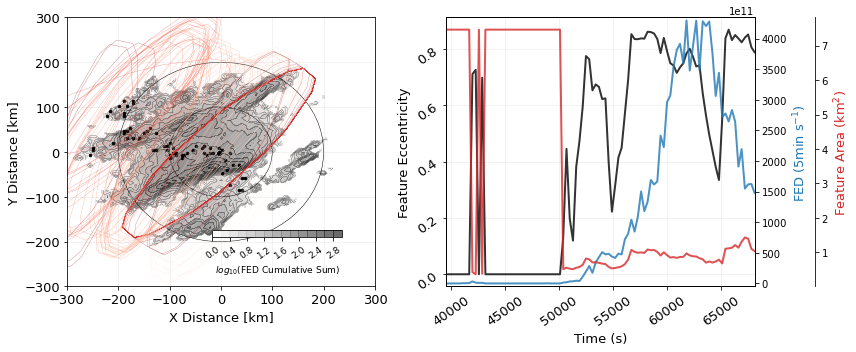

In [51]:
if track_method=='GLM':
    plot_tracking_overview(case,GLM_X,GLM_Y,GLM_GED,good_centx,good_centy,good_patch,good_ids,
                            good_eccs,good_areas,dx,t_frames,skip_times,track_method,set_dt)
else:
    plot_tracking_overview(case,LMA_X,LMA_Y,LMA_FED,good_centx,good_centy,good_patch,good_ids,
                            good_eccs,good_areas,dx,t_frames,skip_times,track_method,set_dt)

# Generate Sample Axis and Points:
-----
The sample axis is generated in the following routine. Again, importlib is called to allow the user to modify the gen_sample_points function without having to re-rerun the entire notebook. Constant arguments are as follow:

    1) smooth_track = sets option to use a smoother to smooth the track centroids, or retain original centroids that vary more in time.
    2) compress_ellipse = Boolean set to compress the sample axis inwards from each focal point. This makes points along sample axis closer together. 
    3) compress_dist    = Value of distance by which to compress sample axis inwards in units km
    4) d                = # of points along sample axis, user configurable
    5) xoffset          = similar to offset, but shifts the points directly instead by some value in x (km)
    6) yoffset          = similar to offset, but shifts the points directly instead by some value in y (km)
    
The sample point generator returns the following variables:

    1) line_rot = rotated sample axis whose orientation matches that of the ellipse
    2) center_x = smoothed centroid x coordinate
    3) center_y = smoothed centroid y coordinate
    4) ex       = ellipse boundary x coordinates
    5) ey       = ellipse boundary y coordinates

In [52]:
import importlib
importlib.reload(bk)
gen_sample_points      = bk.gen_sample_points
plot_tracking_overview = bk.plot_tracking_overview

In [53]:
#Here, a 2nd order polynomial fit is made between feature centroids to approximate a storm track if a smooth tracking feature is desired
#note: smoothing the centroids may result in a loss of flash data that are sampled as the lines will shift (only for gridded interpolations)!
smooth_track     = True #smooth track centroids
compress_ellipse = True #mush sample spacing inwards towards ellispse center
compression_dist = 100#280#150  #km (150 for 211027)
d                = 20   #number of sample points 10 is the default
xoffset          = 0
yoffset          = 0

Smoothing tracked storm centroids
Compressing tracking ellipse to ensure points stay within storm
Reducing semi-major axis length by 100 km
Setting a constant ellipse to sample storm (no expansion/compression with storm growth/decay) 125


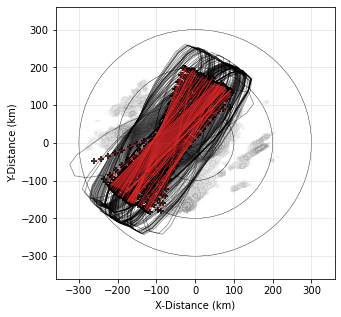

In [54]:
if track_method == 'GLM':
    line_rot,center_x,center_y,ex,ey = gen_sample_points(case,GLM_X,GLM_Y,GLM_GED,constant_feature,smooth_track,
                                                   compress_ellipse,compression_dist,d,good_centx,good_centy,t_frames,get_valid_tidx,
                                                   get_centroidx,get_centroidy,set_width,set_height,get_norientation,
                                                   get_semi_major_len,get_semi_minor_len,
                                                   xoffset,yoffset,set_dt)
else:
    line_rot,center_x,center_y,ex,ey = gen_sample_points(case,LMA_X,LMA_Y,LMA_FED,constant_feature,smooth_track,
                                                   compress_ellipse,compression_dist,d,good_centx,good_centy,t_frames,get_valid_tidx,
                                                   get_centroidx,get_centroidy,set_width,set_height,get_norientation,
                                                   get_semi_major_len,get_semi_minor_len,
                                                   xoffset,yoffset,set_dt)

### Save the following:

    1) The ellipse boundaries at each time frame to netcdf for reconstruction
    2) The sample axis to a netcdf file for reference.

In [55]:
#Save ellipse vertices for smoothed tracking object
ellipse_dataset = xr.Dataset(coords={'time':t_frames[get_valid_tidx],'vert':np.arange(np.array(ex).shape[1])},
                             data_vars={'ellipse_x':(('time','vert'),np.array(ex)),
                                        'ellipse_y':(('time','vert'),np.array(ey)),
                                        't_frames':(('time'),t_frames[get_valid_tidx])})
ellipse_dataset.to_netcdf(f'Output/{set_dt}/TrackedData/{case[2:]}/{case}_Tracked_Ellipse_Verts.nc')

In [56]:
line_sample = xr.Dataset(coords={'time':t_frames[get_valid_tidx],'sample':np.arange(d),'coord':np.arange(2)},
                         data_vars={'sample_line':(('time','sample','coord'),line_rot),
                                    'sample_indx':(('time'),get_valid_tidx)})
line_sample.to_netcdf(f'Output/{set_dt}/TrackedData/{case[2:]}/{case[2:]}_sample_line_dx{d}.nc')

# Generate Sample Grid:
----
The method by which to generate the sampling grid is defined here. Method is to define an offset along the y-axis, generate line segments that span the length of the offset (x2 since it extends North-South of center point along sample axis), and rotate them to intersect orthogonal to convective line.

Below is a better way to define sampling line:
---
Create vertical lines spanning from top to bottom (N-->S) offseting by any value. Then, rotate them to be orthogonal to main line!

In [57]:
set_stepy       = 150 #set how far we want to extend sample segments (N and S) of each point along the sample axis (km)
npoints         = 100 #set number of points to define sample segments
original        = line_sample.sample_line.values #make copy of original sample axis data
new_sample_grid = np.zeros([100,original.shape[0],d,2]) #make new empty array matching original's shape
print(new_sample_grid.shape) #print shape to check dimensions
for t in np.arange(len(t_frames))[:skip_frames]: #Iterate over all available time frames
    for i in range(original.shape[1]):
        y_loc = line_sample.sample_line[t,i,1].values #get ylocations
        x_loc = line_sample.sample_line[t,i,0].values #get xlocations
        #Generate offset locations given the step distance along y
        y_loc0 = y_loc+set_stepy
        y_locf = y_loc-set_stepy
        #Generat sample line segments
        y_steps = np.linspace(y_loc0,y_locf,npoints)
        x_steps = np.repeat(x_loc,npoints)
        #Fill empty array with new sample segment data
        new_sample_grid[:,t,i,0] = x_steps
        new_sample_grid[:,t,i,1] = y_steps

(100, 96, 20, 2)


In [58]:
#Make the new grid sampling without rotation to be orthogonal to main line into a dataset
#-------
grid_sample  = xr.Dataset(coords={'nline':np.arange(x_steps.shape[0]),
                              'time':t_frames[:skip_frames],
                              'sample':np.arange(original.shape[1]),
                              'coord':np.arange(original.shape[2])},
                     data_vars={'sample_line':(('nline','time','sample','coord'),new_sample_grid[:,:,:,:])})
#Only save if needed!
# grid_sample.to_netcdf(f'Output/{set_dt}/TrackedData/{case[2:]}/{case[2:]}_sample_grid_dx{d}_NoRotate.nc')

In [59]:
#Here, we save the variables used to generate the tracked ellipse and sample axis.
#-----------------
import json
#Log all tracking method parameters for reference
method_log = {'gauss_smooth':gauss_smooth,
              'constant_feature':constant_feature,
              'ellipse_height':set_height,
              'ellipse_width':set_width,
              'offset_centroid':offset,
              'smooth_tracking':smooth_track,
              'compress_ellipse':compress_ellipse,
              'compress_inwards_by':compression_dist,
              'num_samples':d,
              'yoffset':set_stepy,
              'adjust':None,
             }

with open(f'Output/{set_dt}/TrackedData/{case[2:]}/{case}_track_log.txt', 'w') as log:
     log.write(json.dumps(method_log))

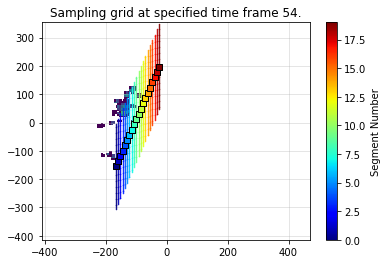

In [74]:
#Check the orignal sample segement data (w/o rotation)
tid = 54
plt.title(f'Sampling grid at specified time frame {tid}.')
# plt.pcolormesh(GLM_X[0]*1e-3,GLM_Y[0]*1e-3,np.log10(GLM_GED[tid]))
plt.pcolormesh(LMA_X*1e-3,LMA_Y*1e-3,np.log10(LMA_FED[tid]))
c = plt.cm.jet(np.linspace(0,1,d))
for i in range(d)[::-1]:
    plt.plot(grid_sample.sample_line[:,tid,i,0].values.flatten(),grid_sample.sample_line[:,tid,i,1].values.flatten(),'.',color=c[i],ms=1);
c=plt.scatter(line_sample.sample_line[tid,:,0].values,line_sample.sample_line[tid,:,1],c=np.arange(d),cmap='jet',marker='s',edgecolor='k',zorder=12);
cbar = plt.colorbar(c)
cbar.ax.set_ylabel('Segment Number')
# plt.scatter(line_sample.sample_line.values[tid,:,0],line_sample.sample_line.values[tid,:,1],marker='+',c='C3')
plt.grid(alpha=0.4)

Here, we make sure that the sample grid is oriented orthogonal to tracking ellipse semi-major axis:
---

In [62]:
def rotate(origin, point, angle):
    """
    src: https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    angle = np.deg2rad(angle)

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

In [63]:
re_orient = (np.hstack(get_norientation)+180) #add 180 to make orthogonal to major axis
get_newx,get_newy = [],[]
for tid in np.arange(len(t_frames))[:skip_frames]:
    for i in range(100):
        for j in range(d):
            re_centx = grid_sample.sample_line[50,tid,j,0].values
            re_centy = grid_sample.sample_line[50,tid,j,1].values
    
            new_xy = rotate(#(center_x[tid],center_y[tid]),
    #                         (line_sample.sample_line[tid,j,0].values,line_sample.sample_line[tid,j,1].values),
                            (re_centx,re_centy),
                                   (grid_sample.sample_line[i,tid,j,0].values.flatten(),
                                    grid_sample.sample_line[i,tid,j,1].values.flatten()),re_orient[tid])
            get_newx.append(new_xy[0]); get_newy.append(new_xy[1])

new_x = np.array(get_newx).reshape(len(t_frames[:skip_frames]),100,d)[:,:]
new_y = np.array(get_newy).reshape(len(t_frames[:skip_frames]),100,d)[:,:]

In [29]:
#Now check the rotated sample segments that define the sampling grid:
#-----------------

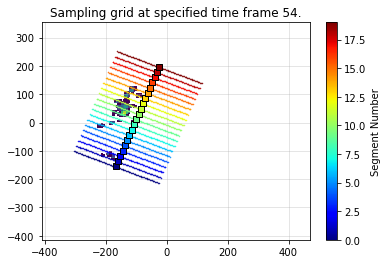

In [75]:
tid = 54
plt.title(f'Sampling grid at specified time frame {tid}.')
# plt.pcolormesh(GLM_X[0]*1e-3,GLM_Y[0]*1e-3,np.log10(GLM_GED[tid]))
plt.pcolormesh(LMA_X*1e-3,LMA_Y*1e-3,np.log10(LMA_FED[tid]))
c = plt.cm.jet(np.linspace(0,1,d))
for i in range(d):
    plt.plot(new_x[tid,:,i],new_y[tid,:,i],'.',color=c[i],ms=1);
c=plt.scatter(line_sample.sample_line[tid,:,0].values,line_sample.sample_line[tid,:,1],c=np.arange(d),cmap='jet',marker='s',edgecolor='k',zorder=12);
cbar = plt.colorbar(c)
cbar.ax.set_ylabel('Segment Number')
# plt.scatter(line_sample.sample_line.values[tid,:,0],line_sample.sample_line.values[tid,:,1],marker='+',c='C3')
plt.grid(alpha=0.4)

In [125]:
#The samples should be ordered from behind to infront of line, currently, data are saved starting from front to back. Can simply reverse axis to handle this during analysis.

In [67]:
new_grid = np.vstack((new_x,new_y)).reshape(2,len(t_frames[:skip_frames]),100,d).T
#For consistency with PERiLS analyses, swap the axes
new_grid = np.swapaxes(np.swapaxes(new_grid,1,0),1,2)

In [68]:
#Save the new grid sampling
#-------
grid_sample_ortho  = xr.Dataset(coords={'nline':np.arange(x_steps.shape[0]),
                                        'time':t_frames[:skip_frames],
                                        'sample':np.arange(original.shape[1]),
                                        'coord':np.arange(original.shape[2])},
                                data_vars={'sample_line':(('nline','time','sample','coord'),new_grid[:,:,:,:])})
grid_sample_ortho.to_netcdf(f'Output/{set_dt}/TrackedData/{case[2:]}/{case[2:]}_sample_grid_dx{d}.nc')

# Test Ellipse:
----------
Check the ellipse geometry data here, does it make sense. Where does it fail. Make note of the times of failure and skip those time frames if desired or re-run the LTR again until results are satisfactory.

In [34]:
import matplotlib as mpl
from shapely import geometry as sgeom

In [35]:
#Open file (whereve it lives)
ellipse = xr.open_dataset(f'Output/{set_dt}/TrackedData/{case[2:]}/{case}_Tracked_Ellipse_Verts.nc') #change path to whever file is saved
e_vx = ellipse.ellipse_x.values
e_vy = ellipse.ellipse_y.values
e_time=ellipse.t_frames.values
#Set the case as a string that matches the file name's date (20211027)
base_date = dt.datetime(int(case[:4]),int(case[4:6]),int(case[6:]),0,0)

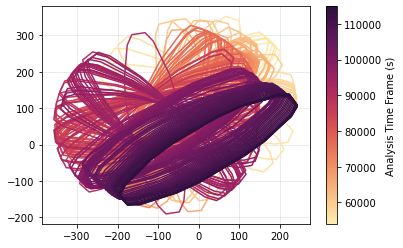

In [36]:
#Plotting all tracked ellipses from 03-08 UTC
fig,ax = plt.subplots(1,1)
norm = mpl.colors.Normalize(vmin=e_time.min(), vmax=e_time.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cm.cm.matter)
cmap.set_array([])
for t in range(e_vx.shape[0]):
    ax.plot(e_vx[t],e_vy[t],color=cmap.to_rgba(e_time[t]))
cb = fig.colorbar(cmap)
cb.ax.set_ylabel('Analysis Time Frame (s)')
plt.grid(alpha=0.3)

Sandbox:
----

For editing and modifying LTR. Future work will explore tracking multiple features and linking those features in space and time to broaded the tracking duration if linear storm systems emerge from intial mixed-mode phase

In [77]:
#Use below for broken lines IOP1 2023 or example.

In [15]:
import importlib
import backendCopy1 as bkc
importlib.reload(bkc)
tracking      = bkc.tracking

In [16]:
(get_eccentricity, get_centroidx, get_centroidy, 
     get_ocentroidx, get_ocentroidy,
     patches,get_ftime,get_path_coords, get_patch_geom, 
     get_semi_major_len,get_semi_minor_len, 
     get_orientation, get_norientation, get_valid_tidx) = tracking(case,base_dat,LMA_X,LMA_Y,LMA_FED,grid_bnds,dx,constant_feature,
                                                                   set_width,set_height,5,offset,t_frames[:skip_frames],set_dt,skip_times,True)

Starting Tracking Routine
Tracking Field: GLM GED
Smoothing Field by sigma=5
Total Time Frames: 132
Tracking Complete.
